In [1]:
import pandas as pd

class Attribute:
    def __init__(self, file_name, entity_type=None):
        try:
            self.df = pd.read_table(file_name, encoding="utf-8")
        except Exception:
            self.df = pd.read_table(file_name, encoding="ansi")
        
        self.attr_name = self.df.columns[0]
        self.vals = self.df[self.attr_name].values
        self.ds = file_name[:3]
        self.name = ":".join([self.ds, self.attr_name])
        self.relation_type = None
        self.entity_type = entity_type
        if self.entity_type == "E21_Person":
            self.relation_type = ("E12_Production", "P14_carried_out_by") if "E12" in file_name else ("E22_Man-Made_Object", "P62_depicts")
        elif self.entity_type == "E52_Time-Span":
            if "E67" in file_name:
                self.relation_type = ("E67_Birth", "P4_has_time-span")
            elif "E69" in file_name:
                self.relation_type = ("E69_Death", "P4_has_time-span")
            elif "E12" in file_name:
                self.relation_type = ("E12_Production", "P4_has_time-span")
            elif "E8" in file_name:
                self.relation_type = ("E8_Acquisition", "P4_has_time-span")
        elif self.entity_type == "E53_Place":
            if "E12_P7" in file_name:
                self.relation_type = ("E12_Production", "P7_took_place_at")
            elif "E21_P74" in file_name:
                self.relation_type = ("E21_Person", "P74_has_current_or_former_residence")
            elif "E67_P7" in file_name:
                self.relation_type = ("E67_Birth", "P7_took_place_at")
            elif "E22_P55" in file_name:
                self.relation_type = ("E22_Man-made_Object", "P55_has_current_location")
        elif self.entity_type == "E55_Type":
            self.relation_type = ("E12_Production", "P32_used_general_technique") if "type1" in file_name else ("E22_Man-Made_Object", "P2_has_type")
    
    def __repr__(self):
        return self.name




In [2]:
import os
os.chdir(r"D:\exp_20211101\E21_Person")

In [3]:
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

nlp = spacy.load("en_core_web_md")

def jaccard_similarity(x, y):
    
    if len(x) < 30:
        return 0
    
    intersection_cardinality = len(set(x) & set(y))
    union_cardinality = len(set(x) | set(y))
    return intersection_cardinality / float(union_cardinality)


def tfidf_cosine_similarity(x, y):
    
    if len(x) < 30:
        return 0
    
    docx = " ".join(set(x))
    docy = " ".join(set(y))
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([docx.lower(), docy.lower()])
    result = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return result

def get_freq_dict(data):
    freq_dict = {}.fromkeys(data, 0)
    for ele in data:
        freq_dict[ele] += 1

    return freq_dict


def get_distribution(data):
    freq_dict = get_freq_dict(data)
    histogram_list = []
    i = 0
    for v in reversed(sorted(freq_dict.values())):
        for _ in range(int(v*100/len(data))):
            histogram_list.append(i)
        i += 1
    return histogram_list


def mann_whitney_test(x, y):
    
    if len(x) < 30:
        return 0
    
    x = get_distribution(x)
    y = get_distribution(y)
    if len(x) > 1 and len(y) > 1:
        if x[-1] != 0 and y[-1] != 0:
            result = stats.mannwhitneyu(x, y)[1]
            return result

    return 0


def attr_rel_similarity(attr_name, rel):
    
    def attr_seg(attr_name):
        s = ""
        if " " not in attr_name:
            for c in attr_name:
                if c.isupper():
                    s += " "
                if c.isalpha():
                    s += c
                else:
                    s += " "
            return s.strip()
        else:
            return attr_name
    
    def rel_seg(r):
        return " ".join(r.split("_")[1:])
    
    attr_name = attr_seg(attr_name)
    
    return nlp(attr_name).similarity(nlp(rel_seg(rel[0]))) + nlp(attr_name).similarity(nlp(rel_seg(rel[1])))

In [6]:
os.chdir(r"D:\exp_20211101\E55_Type")

type_attrs = [Attribute(file, "E55_Type") for file in os.listdir()]

candidate_types = [("E12_Production", "P32_used_general_technique"), ("E22_Man-Made_Object", "P2_has_type")]



In [61]:
import random
random.seed(1)

type_E12_attrs = [attr for attr in type_attrs if attr.relation_type == ("E12_Production", "P32_used_general_technique")]
type_E22_attrs = [attr for attr in type_attrs if attr.relation_type == ("E22_Man-Made_Object", "P2_has_type")]

while True:
    ref_1 = random.choice(type_E12_attrs)
    ref_2 = random.choice(type_E22_attrs)
    if len(ref_1.vals) > 30 and len(ref_2.vals) > 30:
        break

type_E12_attrs.remove(ref_1)
type_E22_attrs.remove(ref_2)




In [62]:
print(ref_1.name)
print(ref_2.name)

s25:Subtype_of_Art_type
s26:type


In [63]:
df = pd.DataFrame(columns = ["Attr_name","Length","Jaccard_ref1","Jaccard_ref2", "TF-IDF_ref1",
                             "TF-IDF_ref2", "MW_ref1", "MW_ref2", "Attr_rel1", "Attr_rel2", "real_relation", "label"])
for attr in type_E12_attrs:
    df = df.append({"Attr_name":attr.name, "Length":len(attr.vals), "Jaccard_ref1":jaccard_similarity(attr.vals, ref_1.vals),
                    "Jaccard_ref2":jaccard_similarity(attr.vals, ref_2.vals), "TF-IDF_ref1":tfidf_cosine_similarity(attr.vals, ref_1.vals),
                    "TF-IDF_ref2":tfidf_cosine_similarity(attr.vals, ref_2.vals), "MW_ref1":mann_whitney_test(attr.vals, ref_1.vals),
                    "MW_ref2":mann_whitney_test(attr.vals, ref_2.vals),"Attr_rel1":attr_rel_similarity(attr.attr_name, candidate_types[0]),
                    "Attr_rel2":attr_rel_similarity(attr.attr_name, candidate_types[1]), "real_relation":attr.relation_type,"label":0}, ignore_index=True)


    
for attr in type_E22_attrs:
    df = df.append({"Attr_name":attr.name, "Length":len(attr.vals), "Jaccard_ref1":jaccard_similarity(attr.vals, ref_1.vals),
                    "Jaccard_ref2":jaccard_similarity(attr.vals, ref_2.vals), "TF-IDF_ref1":tfidf_cosine_similarity(attr.vals, ref_1.vals),
                    "TF-IDF_ref2":tfidf_cosine_similarity(attr.vals, ref_2.vals), "MW_ref1":mann_whitney_test(attr.vals, ref_1.vals),
                    "MW_ref2":mann_whitney_test(attr.vals, ref_2.vals),"Attr_rel1":attr_rel_similarity(attr.attr_name, candidate_types[0]),
                    "Attr_rel2":attr_rel_similarity(attr.attr_name, candidate_types[1]), "real_relation":attr.relation_type,"label":1}, ignore_index=True)



C:\Users\LRSLXD~1\AppData\Local\Temp/ipykernel_11644/1424256672.py:85: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return nlp(attr_name).similarity(nlp(rel_seg(rel[0]))) + nlp(attr_name).similarity(nlp(rel_seg(rel[1])))


In [64]:
df.head()

,Attr_name,Length,Jaccard_ref1,Jaccard_ref2,TF-IDF_ref1,TF-IDF_ref2,MW_ref1,MW_ref2,Attr_rel1,Attr_rel2,real_relation,label
0,s01:Medium,53,0.055556,0.0,0.582406,0.022692,0.021282,0.986844,0.727143,0.679812,"(E12_Production, P32_used_general_technique)",0
1,s02:Object_Facet_Value,43,0.100000,0.0,0.797171,0.000000,0.255859,0.001285,0.858517,1.222888,"(E12_Production, P32_used_general_technique)",0
2,s04:materials,14,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.909513,0.675539,"(E12_Production, P32_used_general_technique)",0
3,s05:Medium,3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.727143,0.679812,"(E12_Production, P32_used_general_technique)",0
4,s06:Medium,30,0.153846,0.0,0.865085,0.000000,0.094076,0.484379,0.727143,0.679812,"(E12_Production, P32_used_general_technique)",0


In [65]:
X = df[["Jaccard_ref1", "Jaccard_ref2", "TF-IDF_ref1","TF-IDF_ref2", "MW_ref1", "MW_ref2", "Attr_rel1", "Attr_rel2"]]
y = df["label"].apply(int)

In [67]:
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns


def exp1(random_state):
    random.seed(random_state)
    train_index = random.sample(range(len(df)), k=10)
    test_index = [_ for _ in range(len(df)) if _ not in train_index]
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    decision_tree = tree.DecisionTreeClassifier(random_state=0, class_weight="balanced")
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    result_df = df[["Attr_name", "label"]].loc[test_index]
    result_df.index = list(range(len(result_df)))
    result_df["pred"] = y_pred
    
    
    rel_dict = {0:"E12_Producton", 1:"E22_Man-Made_Object"}
    
    result_df["label"] = result_df["label"].map(lambda x: rel_dict[x])
    result_df["pred"] = result_df["pred"].map(lambda x: rel_dict[x])
    
    
    dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns, class_names=["E12_Production","E22_Man-Made_Object"])
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    matrix = confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(matrix, index=["E12_Production", "E22_Man-made_Object"], columns=["E12_Production", "E22_Man-made_Object"])

    
    return result_df, graph, matrix_df

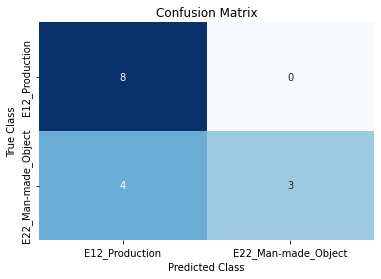

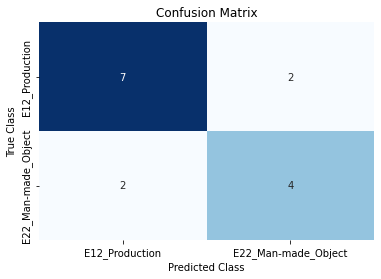

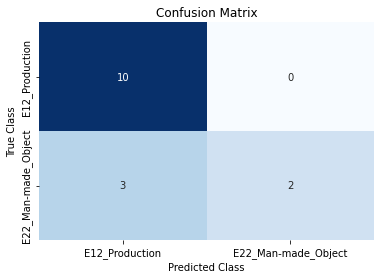

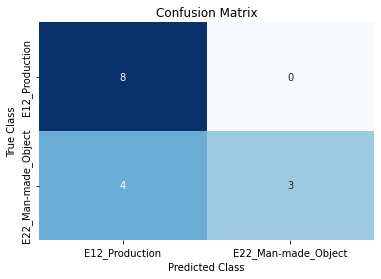

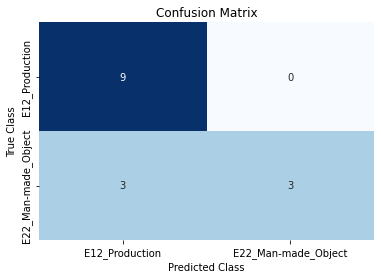

In [68]:
for i in range(1, 6):
    result_df, graph, matrix_df = exp1(i)
    
    result_df.to_csv(f"../result/E55_Type/exp_{i}.csv", index=False)
    graph.write_pdf(f"../result/E55_Type/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"../result/E55_Type/matrix_{i}.pdf")

In [69]:
os.chdir("../E52_Time-Span")

In [70]:
time_span_attrs = [Attribute(file, "E52_Time-Span") for file in os.listdir()]

In [71]:
birth_times = [attr.name for attr in time_span_attrs if attr.relation_type[0] == "E67_Birth"]
death_times = [attr.name for attr in time_span_attrs if attr.relation_type[0] == "E69_Death"]
production_times = [attr.name for attr in time_span_attrs if attr.relation_type[0] == "E12_Production"]
acquisition_times = [attr.name for attr in time_span_attrs if attr.relation_type[0] == "E8_Acquisition"]

In [72]:
ulan_time_results = [(file, pd.read_csv(r"D:\exp_20211101\ULAN_time_search\\"+ file)) for file in os.listdir(r"D:\exp_20211101\ULAN_time_search")]

In [73]:
def ulan_birth_score(attr):
    for file, ulan_result in ulan_time_results:
        if attr.ds == file[:3]:
            return list(ulan_result["birth_date"].values == attr.vals).count(True) / len(attr.vals)

        
def ulan_death_score(attr):
    for file, ulan_result in ulan_time_results:
        if attr.ds == file[:3]:
            return list(ulan_result["death_date"].values == attr.vals).count(True) / len(attr.vals)

In [74]:
E52_rels = [("E67_Birth", "P4_has_time-span"), ("E69_Death", "P4_has_time-span"), ("E12_Production", "P4_has_time-span"), ("E8_Acquisition", "P4_has_time-span")]


In [75]:
E52_df = pd.DataFrame(columns = ["rel1_score", "rel2_score", "rel3_score", "rel4_score", "ulan_birth_score", "ulan_death_score", "real_relation", "label"])

In [76]:
for attr in time_span_attrs:
    rel1_score = attr_rel_similarity(attr.attr_name, E52_rels[0])
    rel2_score = attr_rel_similarity(attr.attr_name, E52_rels[1])
    rel3_score = attr_rel_similarity(attr.attr_name, E52_rels[2])
    rel4_score = attr_rel_similarity(attr.attr_name, E52_rels[3])
    birth_score = ulan_birth_score(attr)
    death_score = ulan_death_score(attr)
    real_realtion = attr.relation_type
    label = E52_rels.index(real_realtion)
    E52_df.loc[attr.name] = [rel1_score, rel2_score, rel3_score, rel4_score, birth_score, death_score, real_realtion, label]
    
E52_df.head()

,rel1_score,rel2_score,rel3_score,rel4_score,ulan_birth_score,ulan_death_score,real_relation,label
s01:Begin Date,1.023825,0.927766,0.860252,0.838082,0.811321,0.000000,"(E67_Birth, P4_has_time-span)",0
s01:Dated,0.440594,0.411914,0.306096,0.318857,0.000000,0.018868,"(E12_Production, P4_has_time-span)",2
s01:End Date,1.065059,1.037504,0.910957,0.884619,0.000000,0.849057,"(E69_Death, P4_has_time-span)",1
s02:Artist Birth Date,1.285433,1.015806,0.818236,0.689519,0.813953,0.000000,"(E67_Birth, P4_has_time-span)",0
s02:Artist Death Date,1.125402,1.260788,0.831545,0.714441,0.000000,0.883721,"(E69_Death, P4_has_time-span)",1


In [77]:
X = E52_df[["rel1_score", "rel2_score", "rel3_score", "rel4_score", "ulan_birth_score", "ulan_death_score"]]

In [78]:
y = E52_df["label"].apply(int)

In [84]:
def exp2(random_state):

    random.seed(random_state)

    train_attrs = []

    train_attrs.extend(random.sample(birth_times, 9))
    train_attrs.extend(random.sample(death_times, 9))
    train_attrs.extend(random.sample(production_times, 8))
    train_attrs.extend(random.sample(acquisition_times, 1))

    test_attrs = [attr.name for attr in time_span_attrs if attr.name not in train_attrs]
    X_train = X.loc[train_attrs]
    X_test = X.loc[test_attrs]
    y_train = y.loc[train_attrs]
    y_test = y.loc[test_attrs]
    
    decision_tree = tree.DecisionTreeClassifier(random_state=0, class_weight="balanced")
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    
    result_df = pd.DataFrame(y_test)
    result_df["pred"] = y_pred
    
    rel_dict = {0:"E67_Birth", 1:"E69_Death", 2:"E12_Production", 3:"E8_Acquisition"}
    
    result_df["label"] = result_df["label"].map(lambda x:rel_dict[x])
    result_df["pred"] = result_df["pred"].map(lambda x:rel_dict[x])
    dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns, class_names=["E67_Birth","E69_Death", "E12_Production", "E8_Acquisition"])
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    matrix = confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(matrix, index=["E67_Birth", "E69_Death", "E12_Production", "E8_Acquisition"], columns=["E67_Birth", "E69_Death", "E12_Production", "E8_Acquisition"])
    
    return result_df, graph, matrix_df
    

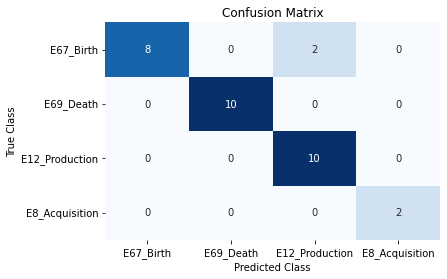

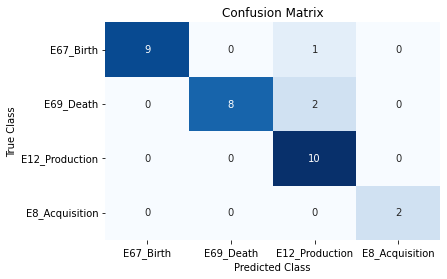

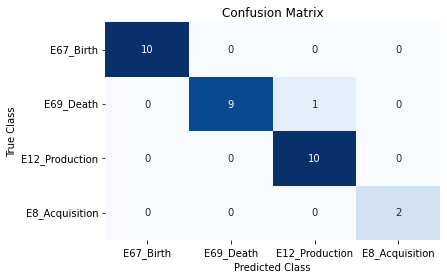

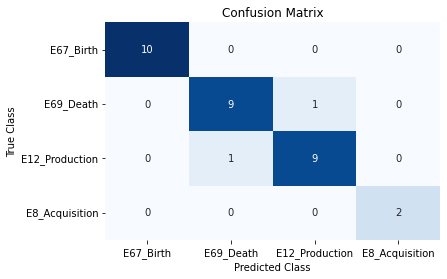

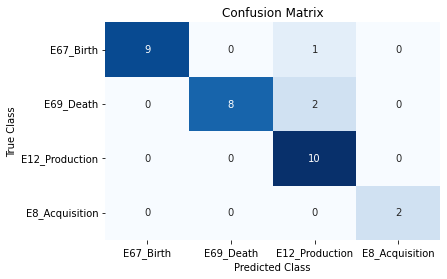

In [85]:
for i in range(1,6):
    result_df, graph, matrix_df = exp2(i)
    
    result_df.to_csv(f"../result/E52_Time-Span/exp_{i}.csv")
    graph.write_pdf(f"../result/E52_Time-Span/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"../result/E52_Time-Span/matrix_{i}.pdf")

In [101]:

os.chdir(r"D:\exp_20211101\E21_Person")


person_attrs = [Attribute(file, "E21_Person") for file in os.listdir()]

In [104]:
for attr in person_attrs:
    print(attr, attr.relation_type)

s01:Attribution ('E12_Production', 'P14_carried_out_by')
s02:Artist Name ('E12_Production', 'P14_carried_out_by')
s03:name ('E12_Production', 'P14_carried_out_by')
s04:artist ('E12_Production', 'P14_carried_out_by')
s05:Who ('E12_Production', 'P14_carried_out_by')
s06:Artist ('E12_Production', 'P14_carried_out_by')
s06:Title ('E22_Man-Made_Object', 'P62_depicts')
s07:name ('E12_Production', 'P14_carried_out_by')
s08:AUTHOR ('E12_Production', 'P14_carried_out_by')
s09:name ('E12_Production', 'P14_carried_out_by')
s10:artist ('E12_Production', 'P14_carried_out_by')
s11:artist_name ('E12_Production', 'P14_carried_out_by')
s12:artist_name ('E12_Production', 'P14_carried_out_by')
s13:Artist name ('E12_Production', 'P14_carried_out_by')
s14:artist ('E12_Production', 'P14_carried_out_by')
s15:name ('E12_Production', 'P14_carried_out_by')
s16:artist ('E12_Production', 'P14_carried_out_by')
s17:artist ('E12_Production', 'P14_carried_out_by')
s18:name ('E12_Production', 'P14_carried_out_by')
s19

In [109]:
random.seed(10)

train_index = random.sample(range(len(person_attrs)), 10)
train_index

[18, 1, 13, 15, 29, 0, 6, 14, 26, 8]

In [113]:
ulan_ids = [(file, pd.read_csv(r"D:\exp_20211101\ULAN_id\\"+ file)) for file in os.listdir(r"D:\exp_20211101\ULAN_id")]

def ulan_person_score(attr):
    if attr.relation_type == ("E22_Man-Made_Object", "P62_depicts"):
        return 1/3
    for file, df in ulan_ids:
        if attr.ds == file[:3]:
            return 1 - (list(df["subject_id"].values).count(0) / len(df))

In [117]:
E21_rels = [("E12_Production", "P14_carried_out_by"), ("E22_Man-Made_Object", "P62_depicts")]
E21_df = pd.DataFrame(columns=["rel1_score", "rel2_score", "ulan_person_score","real_relation", "label"])

for attr in person_attrs:
    rel1_score = attr_rel_similarity(attr.attr_name, E21_rels[0])
    rel2_score = attr_rel_similarity(attr.attr_name, E21_rels[1])
    
    person_score = ulan_person_score(attr)
    
    real_realtion = attr.relation_type
    label = E21_rels.index(real_realtion)
    E21_df.loc[attr.name] = [rel1_score, rel2_score, person_score,real_realtion, label]
    

E21_df

,rel1_score,rel2_score,ulan_person_score,real_relation,label
s01:Attribution,0.314496,0.637045,0.867925,"(E12_Production, P14_carried_out_by)",0
s02:Artist Name,0.649025,0.749760,0.930233,"(E12_Production, P14_carried_out_by)",0
s03:name,0.502767,0.630501,0.796178,"(E12_Production, P14_carried_out_by)",0
s04:artist,0.568408,0.614605,0.928571,"(E12_Production, P14_carried_out_by)",0
s05:Who,0.654243,0.815293,1.000000,"(E12_Production, P14_carried_out_by)",0
s06:Artist,0.568408,0.614605,0.800000,"(E12_Production, P14_carried_out_by)",0
s06:Title,0.360282,0.517390,0.333333,"(E22_Man-Made_Object, P62_depicts)",1
s07:name,0.502767,0.630501,0.693878,"(E12_Production, P14_carried_out_by)",0
s08:AUTHOR,0.469159,0.558691,0.645161,"(E12_Production, P14_carried_out_by)",0
s09:name,0.502767,0.630501,0.250000,"(E12_Production, P14_carried_out_by)",0


True

In [141]:
X = E21_df[["rel1_score", "rel2_score", "ulan_person_score"]]
y = E21_df["label"].apply(int)

def exp3(random_state):

    random.seed(random_state)

    
    train_index = []
    while True:
        train_index = random.sample(range(30), 10)
        if (6 in train_index) ^ (24 in train_index):
            break
            
    train_attrs = [person_attrs[i].name for i in train_index]
    test_attrs = [attr.name for attr in person_attrs if attr.name not in train_attrs]
    
    print(train_attrs)
    print(test_attrs)
    
    X_train = X.loc[train_attrs]
    X_test = X.loc[test_attrs]
    y_train = y.loc[train_attrs]
    y_test = y.loc[test_attrs]
    
    decision_tree = tree.DecisionTreeClassifier(random_state=0, class_weight="balanced")
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    
    result_df = pd.DataFrame(y_test)
    result_df["pred"] = y_pred
    
    rel_dict = {0:"E12_Production", 1:"E22_Man-Made_Object"}
    
    result_df["label"] = result_df["label"].map(lambda x:rel_dict[x])
    result_df["pred"] = result_df["pred"].map(lambda x:rel_dict[x])
    dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns, class_names=["E12_Production", "E22_Man-Made_Object"])
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    matrix = confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(matrix, index=["E12_Production", "E22_Man-Made_Object"], columns=["E12_Production", "E22_Man-Made_Object"])
    
    return result_df, graph, matrix_df

['s05:Who', 's18:name', 's26:artistName', 's24:artist', 's23:Title', 's03:name', 's08:AUTHOR', 's04:artist', 's15:name', 's14:artist']
['s01:Attribution', 's02:Artist Name', 's06:Artist', 's06:Title', 's07:name', 's09:name', 's10:artist', 's11:artist_name', 's12:artist_name', 's13:Artist name', 's16:artist', 's17:artist', 's19:artist', 's20:Artist_Name', 's21:artistName', 's22:Artist_Name', 's23:Artist', 's25:ArtistName', 's28:Maker', 's29:Attribution']
['s19:artist', 's06:Title', 's29:Attribution', 's02:Artist Name', 's18:name', 's21:artistName', 's06:Artist', 's13:Artist name', 's20:Artist_Name', 's12:artist_name']
['s01:Attribution', 's03:name', 's04:artist', 's05:Who', 's07:name', 's08:AUTHOR', 's09:name', 's10:artist', 's11:artist_name', 's14:artist', 's15:name', 's16:artist', 's17:artist', 's22:Artist_Name', 's23:Artist', 's23:Title', 's24:artist', 's25:ArtistName', 's26:artistName', 's28:Maker']
['s25:ArtistName', 's17:artist', 's15:name', 's12:artist_name', 's20:Artist_Name', '

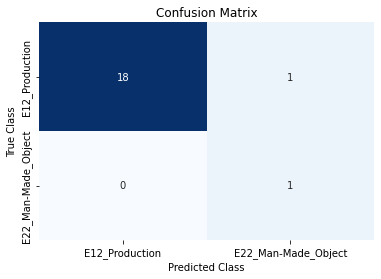

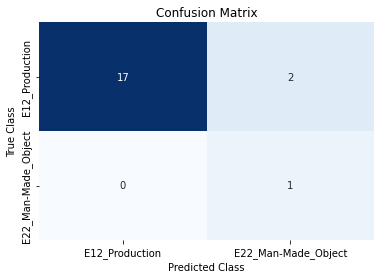

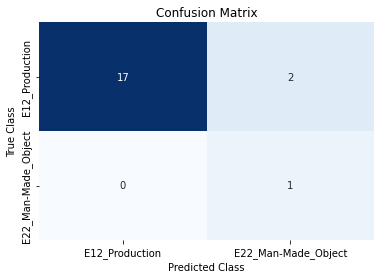

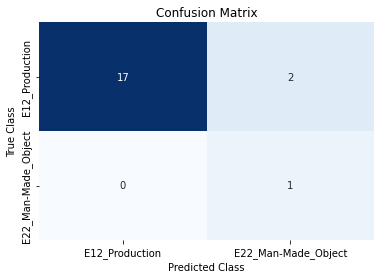

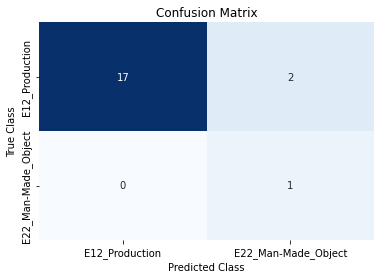

In [142]:
for i in range(1, 6):
    result_df, graph, matrix_df = exp3(i)
    
    result_df.to_csv(f"../result/E21_Person/exp_{i}.csv", index=False)
    graph.write_pdf(f"../result/E21_Person/tree_{i}.pdf")
    plt.figure()
    sns.heatmap(matrix_df, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.savefig(f"../result/E21_Person/matrix_{i}.pdf")

,rel1_score,rel2_score,ulan_person_score
s01:Attribution,0.314496,0.637045,0.867925
s02:Artist Name,0.649025,0.749760,0.930233
s03:name,0.502767,0.630501,0.796178
s04:artist,0.568408,0.614605,0.928571
s05:Who,0.654243,0.815293,1.000000
s06:Artist,0.568408,0.614605,0.800000
s06:Title,0.360282,0.517390,0.333333
s07:name,0.502767,0.630501,0.693878
s08:AUTHOR,0.469159,0.558691,0.645161
s09:name,0.502767,0.630501,0.250000
